# Compare ML vs Gradient results 

In [29]:
import h5py
import pandas as pd
import os
from shapely.geometry import Polygon
from helper_functions import get_coords
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, AutoLocator
import matplotlib.colors as mcol
font = {'family' : 'serif',
         'size'   : 26,
         'serif':  'cmr10'
         }
plt.rc('font', **font)
plt.rc('axes', unicode_minus=False)
plt.rcParams.update({'font.size': 26})
pd.options.mode.chained_assignment = None

import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

In [30]:
# Load all files
def get_h5_file_paths(training_results, name, remove_debug=False):
    if remove_debug:
        filename =   [file[:-10]+".h5" for file in os.listdir(f"{training_results}") if file[-3:] != "pkl"]
        full_paths = [training_results +'/'+ file for file in os.listdir(f"{training_results}") if file[-3:] != "pkl"]
    else:
        filename =   [file for file in os.listdir(f"{training_results}") if file[-3:] != "pkl"]
        full_paths = [training_results +'/'+ file for file in os.listdir(f"{training_results}") if file[-3:] != "pkl"]
        # image_files_FINAL  = [(training_results +'/'+ file, file) for file in os.listdir(f"{training_results}") if file[-3:] != "pkl"]
    return {
        "name":name,
        "filename": filename,
        "full_path": full_paths
    } #(list(map(lambda f: training_results +'/'+f, image_files_FINAL)), image_files_FINAL)

# Gradient
GRADIENT_CZ    = get_h5_file_paths("D:\Granule_experiment_data\ALL_FOURIER_h5\cz_endre/fourier",    name="GRADIENT_CZ")
GRADIENT_AS_02 = get_h5_file_paths("D:\Granule_experiment_data\ALL_FOURIER_h5/as_02_endre/fourier", name="GRADIENT_AS_02")
GRADIENT_AS_31 = get_h5_file_paths("D:\Granule_experiment_data\ALL_FOURIER_h5/as_31_endre/fourier", name="GRADIENT_AS_31")
# ML .h5
ML_CZ    = get_h5_file_paths("D:\Granule_experiment_data\ML_RESULTS\CZ_ML/fourier",    name="ML_CZ",    remove_debug=True)
ML_AS_02 = get_h5_file_paths("D:\Granule_experiment_data\ML_RESULTS\AS_02_ML/fourier", name="ML_AS_02", remove_debug=True)
ML_AS_31 = get_h5_file_paths("D:\Granule_experiment_data\ML_RESULTS\AS_31_ML/fourier", name="ML_AS_31", remove_debug=True)

print(f"{len(ML_AS_02['filename']) == len(GRADIENT_AS_02['filename'])} | {len(ML_AS_02['filename'])} == {len(GRADIENT_AS_02['filename'])}")
print(f"{len(ML_AS_31['filename']) == len(GRADIENT_AS_31['filename'])} | {len(ML_AS_31['filename'])} == {len(GRADIENT_AS_31['filename'])}")
print(f"{len(ML_CZ['filename']) == len(GRADIENT_CZ['filename'])} | {len(ML_CZ['filename'])} == {len(GRADIENT_CZ['filename'])}")
# GRADIENT_AS_02
all_files = [GRADIENT_AS_02, GRADIENT_AS_31, ML_CZ, ML_AS_02, ML_AS_31]
df = pd.DataFrame(GRADIENT_CZ)
for d in all_files:
    df = pd.concat((df, pd.DataFrame(d)))

df.reset_index(drop=True, inplace=True)
df

True | 70 == 70
False | 66 == 65
True | 81 == 81


,name,filename,full_path
0,GRADIENT_CZ,2019-12-09_14.10.10--NCz--T1334--GFP_Burst.h5,D:\Granule_experiment_data\ALL_FOURIER_h5\cz_e...
1,GRADIENT_CZ,2019-12-09_14.11.13--NCz--T1334--GFP_Burst.h5,D:\Granule_experiment_data\ALL_FOURIER_h5\cz_e...
2,GRADIENT_CZ,2019-12-09_14.12.22--NCz--T1334--GFP_Burst.h5,D:\Granule_experiment_data\ALL_FOURIER_h5\cz_e...
3,GRADIENT_CZ,2019-12-09_14.13.37--NCz--T1334--GFP_Burst.h5,D:\Granule_experiment_data\ALL_FOURIER_h5\cz_e...
4,GRADIENT_CZ,2019-12-09_14.14.51--NCz--T1334--GFP_Burst.h5,D:\Granule_experiment_data\ALL_FOURIER_h5\cz_e...
...,...,...,...
428,ML_AS_31,2019-10-31_12.47.30--NControlLongB--T1015-Burs...,D:\Granule_experiment_data\ML_RESULTS\AS_31_ML...
429,ML_AS_31,2019-10-31_12.49.52--NControlLongB--T1015-Burs...,D:\Granule_experiment_data\ML_RESULTS\AS_31_ML...
430,ML_AS_31,2019-10-31_12.51.58--NControlLongB--T1015-Burs...,D:\Granule_experiment_data\ML_RESULTS\AS_31_ML...
431,ML_AS_31,2019-10-31_12.54.48--NControlLongB--T1015-Burs...,D:\Granule_experiment_data\ML_RESULTS\AS_31_ML...


# Analyze files

In [31]:
def analyze_h5_files(ML_PATH: str, GRADIENT_PATH: str, verbose=False):
    # --------------- Load data  ---------------
    fourier_pd_gradient = pd.read_hdf(
        GRADIENT_PATH, key="fourier", mode="r"   
    )
    fourier_pd_ml = pd.read_hdf(
        ML_PATH, key="fourier", mode="r"
    )
    fourier_pd_gradient_valid = fourier_pd_gradient[(fourier_pd_gradient['valid'] == True)]
    fourier_pd_ml_valid = fourier_pd_ml[(fourier_pd_ml['valid'] == True)]
    # assert fourier_pd_gradient_valid['frame'].max() == fourier_pd_ml_valid['frame'].max(), f"Unequal frames! Was {fourier_pd_gradient_valid['frame'].max()} != {fourier_pd_ml_valid['frame'].max()}"
    min_frames = np.min((fourier_pd_gradient_valid['frame'].max(), fourier_pd_ml_valid['frame'].max()))
    # --------------- Valid granules ---------------
    print(f"Current: {pathlib.Path(GRADIENT_PATH).stem}")
    nr_valid = fourier_pd_gradient_valid['granule_id'].unique().size 
    print(f"Valid granules (gradient) | {nr_valid}")
    nr_valid_ml = fourier_pd_ml_valid['granule_id'].unique().size
    print(f"Valid granules (ML) | {nr_valid_ml} \n")
    
    # --------------- Do comparison ---------------
    IoU = []
    area_gradient_list = []
    area_ml_list = []
    granule_ids = [] 
    frames = []
    mean_intensity, mean_radius, major_axis, minor_axis, eccentricity = [],[],[],[],[]

    for frame_id in range(min_frames +1): # For all frames
        granules_in_gradient_frame = fourier_pd_gradient_valid[fourier_pd_gradient_valid['frame'] == frame_id]
        valid_granule_gradient_ids = granules_in_gradient_frame['granule_id'].unique() # All granules

        granules_in_frame_ml = fourier_pd_ml_valid[fourier_pd_ml_valid['frame'] == frame_id]
        # valid_granule_ids_ml = granules_in_frame_ml['granule_id'].unique() # All granules
        # print(valid_granule_ids)
        # print(valid_granule_ids_ml)
        # assert np.array_equal(valid_granule_ids, valid_granule_ids_ml), "Should always be equal"
        
        # TODO: Run this to ensure granule ids are the same for both files!!
        # assert granule_f_gradient_terms['granule_id'].unique() == granule_f_terms_ml['granule_id'].unique(), f"Granule ID's are not the same! Was \n {granule_f_gradient_terms['granule_id'].unique()} \n {granule_f_terms_ml['granule_id'].unique()}"

        for granule_id in valid_granule_gradient_ids: # For all granules in frame       # TODO: Currently only considering granules that are in Gradient! This leaves unique granules that are in ML out!!
            
            granule_f_gradient_terms = granules_in_gradient_frame[granules_in_gradient_frame['granule_id'] == granule_id]
            granule_f_terms_ml = granules_in_frame_ml[granules_in_frame_ml['granule_id'] == granule_id]


            
            if granule_f_terms_ml.size == 0 :#or (granule_f_gradient_terms.iloc[0][['x','y']].tolist() != granule_f_terms_ml.iloc[0][['x','y']].tolist()):
                continue
            elif granule_f_terms_ml['mean_radius'].iloc[0] == 0 or granule_f_gradient_terms['mean_radius'].iloc[0] == 0:
                if verbose:
                    print("\nMean radius was 0!\n")
                    # return # TODO: Test if this is ever triggered!!
                continue
            # Compare x,y positions to verify comparisons happen with correct granules, irrespective of their id's
            if (granule_f_gradient_terms.iloc[0][['x','y']].tolist() != granule_f_terms_ml.iloc[0][['x','y']].tolist()):
                if verbose:
                    print(f"\n Granules not in same position! \n ML F:{granule_f_terms_ml['frame'].iloc[0]} Id: {granule_f_terms_ml['granule_id'].iloc[0]} Gradient F:{granule_f_gradient_terms['frame'].iloc[0]} Id: {granule_f_gradient_terms['granule_id'].iloc[0]}  \n{np.round(granule_f_gradient_terms.iloc[0][['x','y']].tolist(), 4)} != {np.round(granule_f_terms_ml.iloc[0][['x','y']].tolist(), 4)}")
                # return # TODO: Test if this is ever triggered!!
                continue

            xs, ys = get_coords(granule_f_gradient_terms, get_relative=True)
            xy = np.vstack((xs,ys)).T
            area_gradient = Polygon(xy)

            xs_ml, ys_ml = get_coords(granule_f_terms_ml, get_relative=True) 
            xy = np.vstack((xs_ml,ys_ml)).T 
            area_ml = Polygon(xy) 

            if not area_gradient.is_valid or not area_ml.is_valid:
                if verbose:
                    print(f"Invalid Gradient: {area_gradient.is_valid} ML: {area_ml.is_valid}") # TODO: Need to handle invalid geometries. Maybe add to csv, but note as 'invalid_geometry'
                continue 
            intersection = area_gradient.intersection(area_ml).area / area_gradient.union(area_ml).area

            IoU.append(intersection)
            area_gradient_list.append(area_gradient.area)
            area_ml_list.append(area_ml.area)
            granule_ids.append(granule_f_gradient_terms.iloc[0]['granule_id'])
            frames.append(granule_f_gradient_terms.iloc[0]['frame'])
            mean_intensity.append(granule_f_gradient_terms.iloc[0]['mean_intensity'])
            mean_radius.append(granule_f_gradient_terms.iloc[0]['mean_radius'])
            major_axis.append(granule_f_gradient_terms.iloc[0]['major_axis'])
            minor_axis.append(granule_f_gradient_terms.iloc[0]['minor_axis'])
            eccentricity.append(granule_f_gradient_terms.iloc[0]['eccentricity'])        
        
    df = pd.DataFrame({
        "granule_ids": granule_ids,
        "frames": frames,
        "area_gradient":area_gradient_list,
        "area_ml":area_ml_list,
        "IoU":IoU,
        "mean_intensity": mean_intensity,
        "mean_radius": mean_radius,
        "major_axis": major_axis,
        "minor_axis": minor_axis,
        "eccentricity": eccentricity,
    })
    df['Gradient_valid'] = nr_valid
    df['ML_valid'] = nr_valid_ml
    df.to_csv(f"D:\Master\MasterProject\GE_result_analysis\comparison_results/{pathlib.Path(GRADIENT_PATH).stem}.cvs")

## Run only on files that have a Gradient & ML Pair 

In [32]:
REPLACE = False
for experiment_pair in [('GRADIENT_CZ', 'ML_CZ'),('GRADIENT_AS_02', 'ML_AS_02'),('GRADIENT_AS_31', 'ML_AS_31')]:
    gradient_ex_name, ml_ex_name = experiment_pair
    
    gradient_ex = df[df['name'] == gradient_ex_name]
    ml_ex = df[df['name'] == ml_ex_name]

    for index, row in gradient_ex.iterrows():
        # Check that GRADIENT has a matching ML file
        ml_match = ml_ex[ml_ex['filename'] == row['filename']].iloc[0]
        # print(ml_match)
        if row['filename'] != ml_match['filename']: 
            print("Failed to find match!")
            print(row['filename'], "has no ML variant!")
            continue

        assert not (pathlib.Path(ml_match['full_path']).stem == pathlib.Path(row['full_path']).stem), f"Files are not the same! Was: {pathlib.Path(ml_match['full_path']).stem} != { pathlib.Path(row['full_path']).stem}" 
        
        # ----- Skip training if already done -----
        potential_file = pathlib.Path(f"D:\Master\MasterProject\GE_result_analysis\comparison_results/{pathlib.Path(row['full_path']).stem}.cvs")
        if potential_file.exists():
            if not REPLACE:
                print(f"Results already exists for {pathlib.Path(row['full_path']).stem}. Skipping \n")
                continue
        analyze_h5_files(ml_match['full_path'], row['full_path'], verbose=False)
    #     break
    # break
        

Results already exists for 2019-12-09_14.10.10--NCz--T1334--GFP_Burst. Skipping 

Results already exists for 2019-12-09_14.11.13--NCz--T1334--GFP_Burst. Skipping 

Results already exists for 2019-12-09_14.12.22--NCz--T1334--GFP_Burst. Skipping 

Results already exists for 2019-12-09_14.13.37--NCz--T1334--GFP_Burst. Skipping 

Results already exists for 2019-12-09_14.14.51--NCz--T1334--GFP_Burst. Skipping 

Results already exists for 2019-12-09_14.16.03--NCz--T1334--GFP_Burst. Skipping 

Results already exists for 2019-12-09_14.17.18--NCz--T1334--GFP_Burst. Skipping 

Results already exists for 2019-12-09_14.19.09--NCz--T1334--GFP_Burst. Skipping 

Results already exists for 2019-12-09_14.23.42--NCz--T1334--GFP_Burst. Skipping 

Results already exists for 2019-12-09_14.24.56--NCz--T1334--GFP_Burst. Skipping 

Results already exists for 2019-12-09_14.26.19--NCz--T1334--GFP_Burst. Skipping 

Results already exists for 2019-12-09_14.27.38--NCz--T1334--GFP_Burst. Skipping 

Results already 

# Aggregate fittings

In [33]:
def get_agg(training_results, name):
    # filename =   [file[:-10]+".h5" for file in os.listdir(f"{training_results}") if file[-3:] != ".h5"]
    full_paths = [training_results +'/'+ file for file in os.listdir(f"{training_results}") if file[-3:] == ".h5"]
    # print(full_paths)

    agg_df = pd.read_hdf(full_paths[0], key="aggregate_data", mode="r")
    # print(agg_df.shape)
    for f in full_paths[1:]: # Read and concat all Aggregate_fittings.h5 files 
        loaded_df = pd.read_hdf(f, key="aggregate_data", mode="r")
        agg_df = pd.concat((agg_df, loaded_df))
        # print(agg_df.shape)

    return {
        "name":name,
        "data":agg_df
    } 

# Gradient
GRADIENT_CZ    = get_agg("D:\Granule_experiment_data\ALL_FOURIER_h5\cz_endre",    name="GRADIENT_CZ")
GRADIENT_AS_02 = get_agg("D:\Granule_experiment_data\ALL_FOURIER_h5/as_02_endre", name="GRADIENT_AS_02")
GRADIENT_AS_31 = get_agg("D:\Granule_experiment_data\ALL_FOURIER_h5/as_31_endre", name="GRADIENT_AS_31")
# ML .h5
ML_CZ    = get_agg("D:\Granule_experiment_data\ML_RESULTS\CZ_ML",    name="ML_CZ",  )
ML_AS_02 = get_agg("D:\Granule_experiment_data\ML_RESULTS\AS_02_ML", name="ML_AS_02")
ML_AS_31 = get_agg("D:\Granule_experiment_data\ML_RESULTS\AS_31_ML", name="ML_AS_31")

print(GRADIENT_CZ['data'].shape, ML_CZ['data'].shape)
print(GRADIENT_AS_02['data'].shape, ML_AS_02['data'].shape)
print(GRADIENT_AS_31['data'].shape, ML_AS_31['data'].shape)
print("\n")

for pair in [(GRADIENT_CZ, ML_CZ), (GRADIENT_AS_02, ML_AS_02), (GRADIENT_AS_31, ML_AS_31)]:
    aggregate_fittings_gradient, aggregate_fittings_ml = pair
    aggregate_fittings_gradient, aggregate_fittings_ml = aggregate_fittings_gradient['data'], aggregate_fittings_ml['data']

    aggregate_fittings_gradient = aggregate_fittings_gradient.query("sigma > 1e-10 and pass_rate > 0.6 and fitting_error < 0.6 and fitting_diff > 0.03")
    aggregate_fittings_ml = aggregate_fittings_ml.query("sigma > 1e-10 and pass_rate > 0.6 and fitting_error < 0.6 and fitting_diff > 0.03")

    print("ML granules       ", aggregate_fittings_ml.shape[0])
    print("Gradient granules ", aggregate_fittings_gradient.shape[0])
    
    aggregate_merge = pd.merge(aggregate_fittings_gradient, aggregate_fittings_ml, how='inner', on=['x','y']) # 'granule_id',
    assert (aggregate_merge['granule_id_x'] == aggregate_merge['granule_id_y']).all(), f"All granules are NOT the same across files."

    print("Granules in common", aggregate_merge.shape[0]) # Add 'x', 'y' to check if granules are the same    
    print("\n")
    # break

# print(aggregate_fittings_gradient['granule_id'].value_counts())
# print(aggregate_fittings_ml['granule_id'].value_counts())

(4400, 24) (4400, 24)
(7317, 24) (7317, 24)
(4516, 24) (4462, 24)


ML granules        963
Gradient granules  1301
Granules in common 740


ML granules        1203
Gradient granules  1633
Granules in common 952


ML granules        705
Gradient granules  1004
Granules in common 518




In [34]:
GRADIENT_CZ['data'][:4]

,granule_id,sigma,sigma_err,kappa_scale,kappa_scale_err,mean_radius,figure_path,pass_rate,fitting_error,durbin_watson,...,bbox_left,bbox_bottom,bbox_right,bbox_top,q_2_mag,experiment,timestamp,fitting_diff,sigma_st,sigma_errST
0,0,-1.850721e-08,-1.051356e-07,5.416146,0.681898,0.721299,2019-12-09_15.25.36--NCz--T1437--GFP_Burst--G0...,0.958,0.344650,1.008461,...,471,241,499,267,0.003705,clotrimazole_tracking,2019-12-09T15:25:37.322,4.237396,0.000004,1.588926e-06
1,1,7.210541e-08,7.616003e-08,3.337612,0.318731,0.689040,2019-12-09_15.25.36--NCz--T1437--GFP_Burst--G0...,0.842,0.177090,1.561997,...,544,201,572,227,0.000595,clotrimazole_tracking,2019-12-09T15:25:37.322,3.323259,0.000003,1.008973e-06
2,2,-8.414507e-08,-4.632093e-08,4.630675,0.360100,0.686349,2019-12-09_15.25.36--NCz--T1437--GFP_Burst--G0...,0.947,0.141432,0.544416,...,732,176,759,203,0.000311,clotrimazole_tracking,2019-12-09T15:25:37.322,4.720405,0.000004,1.468305e-06
3,3,1.006165e-07,4.823713e-08,2.439662,0.157105,0.658839,2019-12-09_15.25.36--NCz--T1437--GFP_Burst--G0...,0.813,0.075630,1.925215,...,773,165,800,191,0.001166,clotrimazole_tracking,2019-12-09T15:25:37.322,2.962208,0.000003,7.816563e-07


In [35]:
GRADIENT_CZ['data'].columns.values

array(['granule_id', 'sigma', 'sigma_err', 'kappa_scale',
       'kappa_scale_err', 'mean_radius', 'figure_path', 'pass_rate',
       'fitting_error', 'durbin_watson', 'mean_intensity', 'image_path',
       'x', 'y', 'bbox_left', 'bbox_bottom', 'bbox_right', 'bbox_top',
       'q_2_mag', 'experiment', 'timestamp', 'fitting_diff', 'sigma_st',
       'sigma_errST'], dtype=object)

# Surface tension

In [36]:
aggregate_merge.rename(columns={'sigma_x':'sigma_gradient', 'sigma_err_x':'sigma_err_gradient','sigma_y':'sigma_ml', 'sigma_err_y':'sigma_err_ml'}, inplace=True)
# cols = ['granule_id', 'sigma_ml', 'sigma_err_ml', 'gradient_sigma_in_range_ml', 'ml_sigma_in_range_gradient', 'sigma_in_both_ranges']
combined_df = aggregate_merge#[['granule_id_x', 'sigma_ml', 'sigma_err_ml', 'sigma_gradient', 'sigma_err_gradient', 'gradient_sigma_in_range_ml', 'ml_sigma_in_range_gradient', 'sigma_in_both_ranges']]

lower =  combined_df['sigma_ml'] - combined_df['sigma_err_ml']
higher = combined_df['sigma_ml'] + combined_df['sigma_err_ml']
combined_df['gradient_sigma_in_range_ml'] = (lower <= combined_df['sigma_gradient']) & (combined_df['sigma_gradient'] <= higher)

lower =  combined_df['sigma_gradient'] - combined_df['sigma_err_gradient']
higher = combined_df['sigma_gradient'] + combined_df['sigma_err_gradient']
combined_df['ml_sigma_in_range_gradient'] = (lower <= combined_df['sigma_ml']) & (combined_df['sigma_ml'] <= higher)

combined_df['sigma_in_both_ranges'] = (combined_df['ml_sigma_in_range_gradient'] & combined_df['gradient_sigma_in_range_ml'])

import matplotlib
colors = matplotlib.colors.to_rgba_array(["g", "r"])
combined_df['both_in_range_color']     = [colors[0] if x else colors[1] for x in combined_df['sigma_in_both_ranges']] 
combined_df['both_in_range_color']     = [colors[0] if x else colors[1] for x in combined_df['sigma_in_both_ranges']] 
combined_df['gradient_in_range_color'] = [colors[0] if x else colors[1] for x in combined_df['gradient_sigma_in_range_ml']] 
combined_df['ML_in_range_color']       = [colors[0] if x else colors[1] for x in combined_df['ml_sigma_in_range_gradient']] 

# Calc std distance between ML to gradient relative to gradient
combined_df['std_sigma_distance'] = (combined_df['sigma_ml'] - combined_df['sigma_gradient']) / combined_df['sigma_err_gradient']
combined_df['std_sigma_distance_gradient_to_ml'] = (combined_df['sigma_ml'] - combined_df['sigma_gradient']) / combined_df['sigma_err_ml']

# combined_df.to_csv("Sigma_in_range.csv")
combined_df[:4]

,granule_id_x,sigma_gradient,sigma_err_gradient,kappa_scale_x,kappa_scale_err_x,mean_radius_x,figure_path_x,pass_rate_x,fitting_error_x,durbin_watson_x,...,sigma_st_y,sigma_errST_y,gradient_sigma_in_range_ml,ml_sigma_in_range_gradient,sigma_in_both_ranges,both_in_range_color,gradient_in_range_color,ML_in_range_color,std_sigma_distance,std_sigma_distance_gradient_to_ml
0,13,1.094755e-07,1.843716e-07,6.225401,0.761551,0.664036,2019-10-31_11.42.32--NControlLongB--T1015-Burs...,0.9750,0.297029,0.339794,...,2.680251e-06,8.831269e-07,True,True,True,"[0.0, 0.5, 0.0, 1.0]","[0.0, 0.5, 0.0, 1.0]","[0.0, 0.5, 0.0, 1.0]",0.143180,0.208146
1,18,4.568661e-07,1.225536e-07,1.142347,0.113794,0.627780,2019-10-31_11.42.32--NControlLongB--T1015-Burs...,0.7235,0.090246,0.695155,...,1.050182e-06,2.632607e-07,False,False,False,"[1.0, 0.0, 0.0, 1.0]","[1.0, 0.0, 0.0, 1.0]","[1.0, 0.0, 0.0, 1.0]",-2.402632,-3.724298
2,24,1.902456e-07,5.005052e-08,1.711313,0.095453,0.593139,2019-10-31_11.42.32--NControlLongB--T1015-Burs...,0.7500,0.048875,1.957013,...,9.554955e-07,2.396347e-07,False,False,False,"[1.0, 0.0, 0.0, 1.0]","[1.0, 0.0, 0.0, 1.0]","[1.0, 0.0, 0.0, 1.0]",-1.827095,-3.882217
3,29,3.531815e-07,5.927307e-08,0.909373,0.047920,0.497569,2019-10-31_11.42.32--NControlLongB--T1015-Burs...,0.7250,0.032260,1.846225,...,8.338804e-07,2.229725e-07,False,False,False,"[1.0, 0.0, 0.0, 1.0]","[1.0, 0.0, 0.0, 1.0]","[1.0, 0.0, 0.0, 1.0]",-4.744036,-13.449192


Text(0, 0.5, ' ')

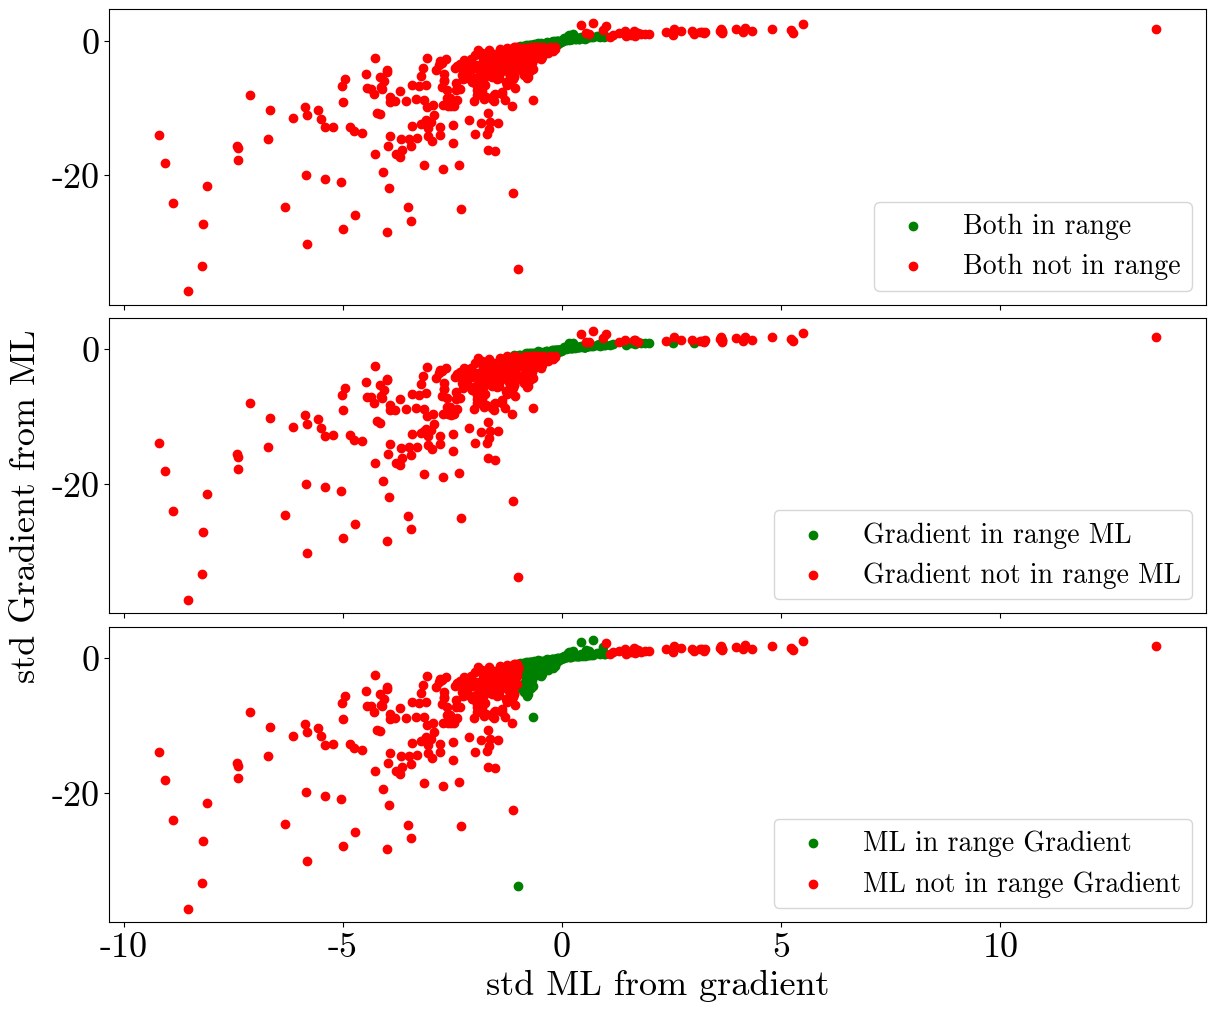

In [37]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), layout='constrained',
                                  sharex=True, sharey=True,)

for t in [True, False]:
    if t:
        color = 'g'
    else:
        color = 'r'
    
    copy_df = combined_df.copy(deep=True)

    label = "Both in range" if t else "Both not in range"
    # ax1.scatter(copy_df[copy_df['sigma_in_both_ranges'] == t]['std_sigma_distance'], 
    #             list(1 for _ in range(len(copy_df[copy_df['sigma_in_both_ranges'] == t]['std_sigma_distance']))), 
    #             c=color, label=label) #, 'o', ls='-', ms=4)

    ax1.scatter(copy_df[copy_df['sigma_in_both_ranges'] == t]['std_sigma_distance'], 
                copy_df[copy_df['sigma_in_both_ranges'] == t]['std_sigma_distance_gradient_to_ml'], 
                c=color, label=label) #, 'o', ls='-', ms=4)
    # ax1.set_ylabel('Max error (%)')
    # ax1.set_xlabel('std ML from gradient')
    # ax1.set_ylabel('std Gradient from ML')
    ax1.legend(loc='lower right', prop={'size': 20})

    label = "Gradient in range ML" if t else "Gradient not in range ML"
    ax2.scatter(copy_df[copy_df['gradient_sigma_in_range_ml'] == t]['std_sigma_distance'], 
                # list(1 for _ in range(len(copy_df[copy_df['gradient_sigma_in_range_ml'] == t]['gradient_sigma_in_range_ml']))), 
                copy_df[copy_df['gradient_sigma_in_range_ml'] == t]['std_sigma_distance_gradient_to_ml'],
                c=color, label=label, ) #, 'o', ls='-', ms=4)
    # ax2.set_ylabel('Max error (%)')
    # ax2.set_xlabel('std away from gradient')
    ax2.legend(loc='lower right', prop={'size': 20})

    label = "ML in range Gradient" if t else "ML not in range Gradient"
    ax3.scatter(copy_df[copy_df['ml_sigma_in_range_gradient'] == t]['std_sigma_distance'], 
                # list(1 for _ in range(len(copy_df[copy_df['ml_sigma_in_range_gradient'] == t]['ml_sigma_in_range_gradient']))), 
                copy_df[copy_df['ml_sigma_in_range_gradient'] == t]['std_sigma_distance_gradient_to_ml'], 
                c=color, label=label, ) #, 'o', ls='-', ms=4)
    # ax3.set_ylabel('Max error (%)')
    # ax3.set_xlabel('std away from gradient')
    ax3.legend(loc='lower right',  prop={'size': 20})

# fig.text(0.5, 0.04, 'common X', ha='center')
fig.text(0.00, 0.5, 'std Gradient from ML', va='center', rotation='vertical')

plt.xlabel("std ML from gradient")
# plt.ylabel("std Gradient from ML", loc='top')
plt.ylabel(" ")

# fig.show()
# fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter4/scaling_error.svg")